# Tutorial 2: Working with Different Data Types

The Multimodal Universe contains four main types of astronomical data:
1. **Images** - Galaxy and star images from various surveys
2. **Spectra** - Wavelength vs flux measurements
3. **Time Series** - Brightness variations over time
4. **Catalogs** - Tabular data with measurements and properties

This notebook shows you (generally) how to work with each type.

## Setup

Import all packages we'll need:

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib defaults for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print('Ready to explore different data types!')

Ready to explore different data types!


## 1. Images - Galaxy Morphology

Let's load galaxy images from the `gz10` dataset (Galaxy10 DECaLS). (A reminder that more information about every data source can be found in the arxiv paper. If you are having trouble, don't hesitate to reach out.)

In [2]:
# Load Galaxy Zoo 10 dataset
print('Loading Galaxy Zoo 10 (gz10) dataset...')
galaxy_data = load_dataset(
    "MultimodalUniverse/gz10",
    split="train",
    streaming=True
)

# Get first example
galaxy = next(iter(galaxy_data))
print(f'Keys: {list(galaxy.keys())}')
print(f'Galaxy label: {galaxy["gz10_label"]}')

Loading Galaxy Zoo 10 (gz10) dataset...
Keys: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale']
Galaxy label: 0


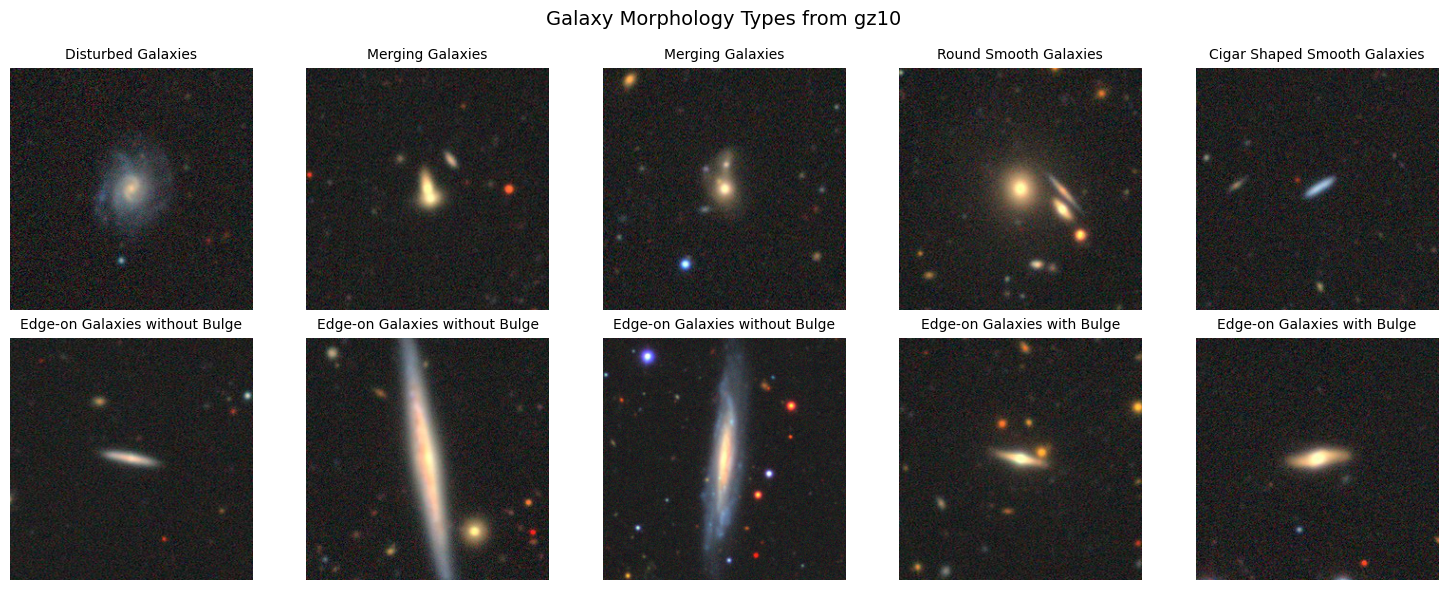

In [3]:
# Display multiple galaxy types
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Galaxy class names from Galaxy Zoo
# See: https://astronn.readthedocs.io/en/latest/galaxy10.html
class_names = [
    'Disturbed Galaxies',
    'Merging Galaxies',
    'Round Smooth Galaxies',
    'In-between Round Smooth Galaxies',
    'Cigar Shaped Smooth Galaxies',
    'Barred Spiral Galaxies',
    'Unbarred Tight Spiral Galaxies',
    'Unbarred Loose Spiral Galaxies',
    'Edge-on Galaxies without Bulge',
    'Edge-on Galaxies with Bulge'
]

# Load 10 galaxies
galaxy_iter = iter(galaxy_data)
for i in range(10):
    galaxy = next(galaxy_iter)
    
    # The image is stored as 'rgb_image' in gz10
    image = galaxy['rgb_image']
    label = galaxy['gz10_label']
    
    # Convert PIL image to numpy if needed
    if hasattr(image, 'convert'):
        image = np.array(image)
    
    # Display image
    axes[i].imshow(image)
    axes[i].set_title(f'{class_names[label]}', fontsize=10)
    axes[i].axis('off')

plt.suptitle('Galaxy Morphology Types from gz10', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Spectra - SDSS Galaxy Spectra

Spectra reveal chemical composition, redshift, and other properties:

In [4]:
# Load SDSS spectroscopic data
print('Loading SDSS spectra...')
sdss_data = load_dataset(
    "MultimodalUniverse/sdss",
    split="train",
    streaming=True  # Use streaming to avoid timeout
)

# Check first spectrum
spectrum = next(iter(sdss_data))
print(f'Available fields: {list(spectrum.keys())[:10]}...')  # Show first 10 fields
print(f'Redshift (Z): {spectrum["Z"]:.4f}')

# The spectrum is stored as a dictionary
spec_data = spectrum['spectrum']
print(f'Spectrum keys: {list(spec_data.keys())}')

Loading SDSS spectra...


Available fields: ['spectrum', 'VDISP', 'VDISP_ERR', 'Z', 'Z_ERR', 'ZWARNING', 'SPECTROFLUX_U', 'SPECTROFLUX_G', 'SPECTROFLUX_R', 'SPECTROFLUX_I']...
Redshift (Z): 0.1026
Spectrum keys: ['flux', 'ivar', 'lsf_sigma', 'lambda', 'mask']


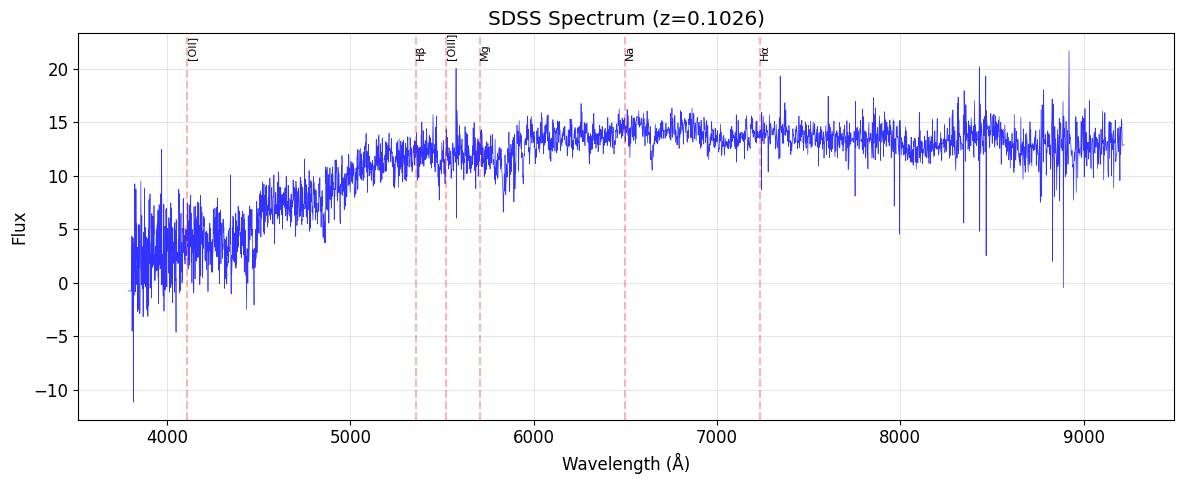

In [ ]:
# Plot a galaxy spectrum
plt.figure(figsize=(12, 5))

# Get spectrum data
spec_data = spectrum['spectrum']
wavelength = np.array(spec_data['lambda'])  # SDSS uses 'lambda' not 'wavelength'
flux = np.array(spec_data['flux'])

# Plot spectrum
plt.plot(wavelength, flux, 'b-', linewidth=0.5, alpha=0.8)

# Mark common emission/absorption lines (vacuum wavelengths in Angstroms)
# Note that the galaxy is redshifted, so lines will appear at longer wavelengths
lines = {
    "Hα": 6563, "Hβ": 4861, "[OIII]": 5007, 
    "Mg": 5175, "Na": 5893, "[OII]": 3727
}

# Apply redshift correction
z = spectrum['Z']
for name, rest_wave in lines.items():
    obs_wave = rest_wave * (1 + z)
    if wavelength[0] < obs_wave < wavelength[-1]:
        plt.axvline(obs_wave, color='red', alpha=0.3, linestyle='--')
        plt.text(obs_wave, plt.ylim()[1]*0.9, name, 
                rotation=90, fontsize=8)

plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title(f'SDSS Spectrum (z={z:.4f})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Time Series - TESS Light Curves

TESS observes stars to find exoplanets and study stellar variability:

In [6]:
# Load TESS data
print('Loading TESS light curves...')
tess_data = load_dataset(
    "MultimodalUniverse/tess",
    split="train",
    streaming=True
)

# Get an example
tess_example = next(iter(tess_data))

print(f'Object ID: {tess_example["object_id"]}')
# Note: TESS uses uppercase RA/DEC
print(f'Coordinates: RA={tess_example["RA"]:.4f}, DEC={tess_example["DEC"]:.4f}')

# Lightcurve structure
lc = tess_example['lightcurve']
print(f'Lightcurve keys: {list(lc.keys())}')

Loading TESS light curves...


Object ID: 229761376
Coordinates: RA=281.3371, DEC=65.9218
Lightcurve keys: ['time', 'flux', 'flux_err']


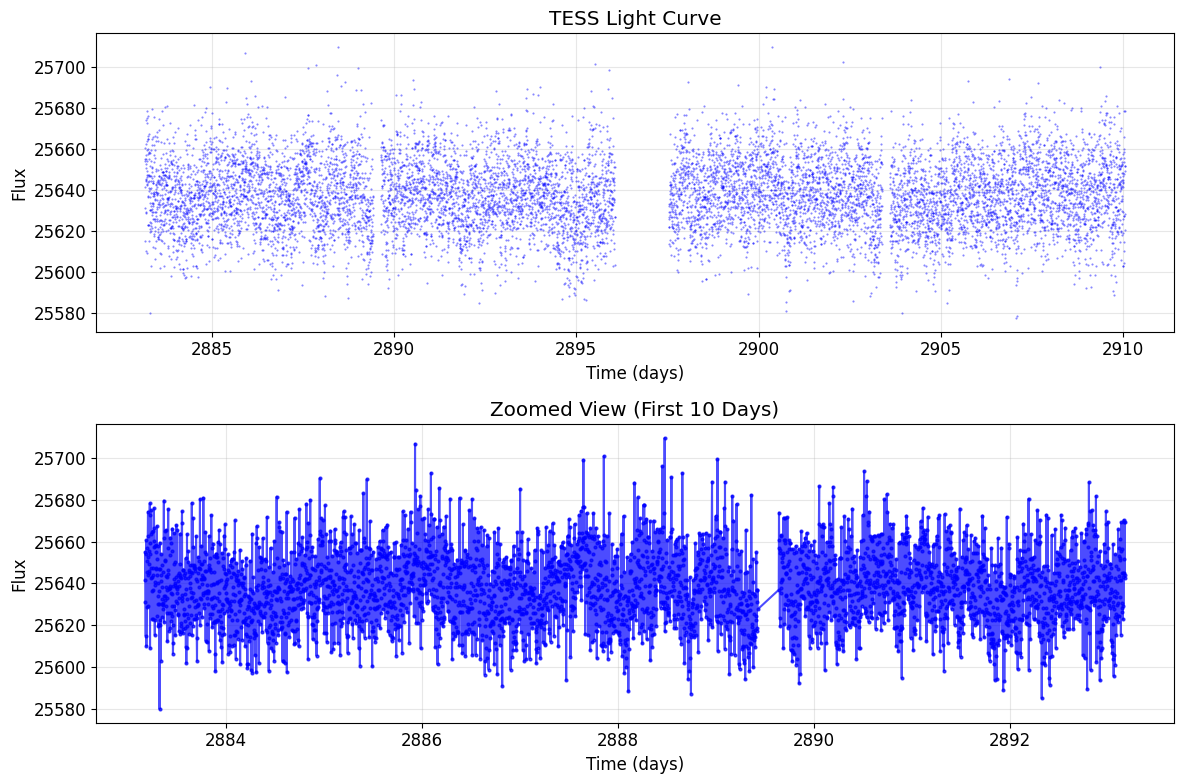

In [7]:
# Extract and plot TESS light curve
lightcurve = tess_example['lightcurve']

# Get time and flux
times = np.array(lightcurve['time'])
flux = np.array(lightcurve['flux'])

# Remove NaN values
mask = ~np.isnan(flux) & ~np.isnan(times)
times = times[mask]
flux = flux[mask]

# Plot light curve
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Full light curve
ax1.plot(times, flux, 'b.', markersize=1, alpha=0.5)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Flux')
ax1.set_title('TESS Light Curve')
ax1.grid(True, alpha=0.3)

# Zoom in on first 10 days
if len(times) > 100:
    zoom_mask = times < times[0] + 10
    ax2.plot(times[zoom_mask], flux[zoom_mask], 'b.-', 
            markersize=4, alpha=0.7)
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Flux')
    ax2.set_title('Zoomed View (First 10 Days)')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Catalogs - Gaia Stellar Data

Gaia provides precise measurements for billions of stars:

In [8]:
# Load Gaia catalog data
print('Loading Gaia catalog...')
gaia_data = load_dataset(
    "MultimodalUniverse/gaia",
    split="train[:1000]",  # Load 1000 stars
    streaming=False
)

# Note: Gaia uses lowercase ra/dec
first_star = gaia_data[0]
print(f'Object ID: {first_star["object_id"]}')
print(f'Coordinates: ra={first_star["ra"]:.6f}, dec={first_star["dec"]:.6f}')

# Check for astrometry data
if 'astrometry' in first_star:
    astro = first_star['astrometry']
    print(f'Astrometry keys: {list(astro.keys())[:5]}...')

Loading Gaia catalog...


Object ID: 4295806720
Coordinates: ra=44.996155, dec=0.005615
Astrometry keys: ['ra', 'ra_error', 'dec', 'dec_error', 'parallax']...


In [9]:
# Extract key Gaia measurements
ra_list = []
dec_list = []
parallax_list = []
pmra_list = []
pmdec_list = []

for i in range(len(gaia_data)):
    star = gaia_data[i]
    ra_list.append(star['ra'])
    dec_list.append(star['dec'])
    
    # Extract from astrometry dictionary
    if 'astrometry' in star:
        astro = star['astrometry']
        parallax_list.append(astro.get('parallax', np.nan))
        pmra_list.append(astro.get('pmra', np.nan))
        pmdec_list.append(astro.get('pmdec', np.nan))

# Create DataFrame
gaia_df = pd.DataFrame({
    'ra': ra_list,
    'dec': dec_list,
    'parallax': parallax_list,
    'pmra': pmra_list,
    'pmdec': pmdec_list
})

print(f'\nGaia DataFrame shape: {gaia_df.shape}')
print('\nBasic statistics:')
print(gaia_df.describe())


Gaia DataFrame shape: (1000, 5)

Basic statistics:
                ra          dec    parallax        pmra       pmdec
count  1000.000000  1000.000000  994.000000  994.000000  994.000000
mean     45.138132     0.926369    1.687625    9.063996   -7.807796
std       0.554841     0.353824    1.891931   19.607758   16.212582
min      43.982067     0.005615   -1.154093  -98.230682 -160.625168
25%      44.697849     0.688171    0.603866    0.539569  -11.457283
50%      45.117798     0.933375    1.113692    4.892835   -5.397897
75%      45.544835     1.175013    2.024878   12.674412   -0.503632
max      46.374786     1.770154   22.499346  220.147552  103.677475


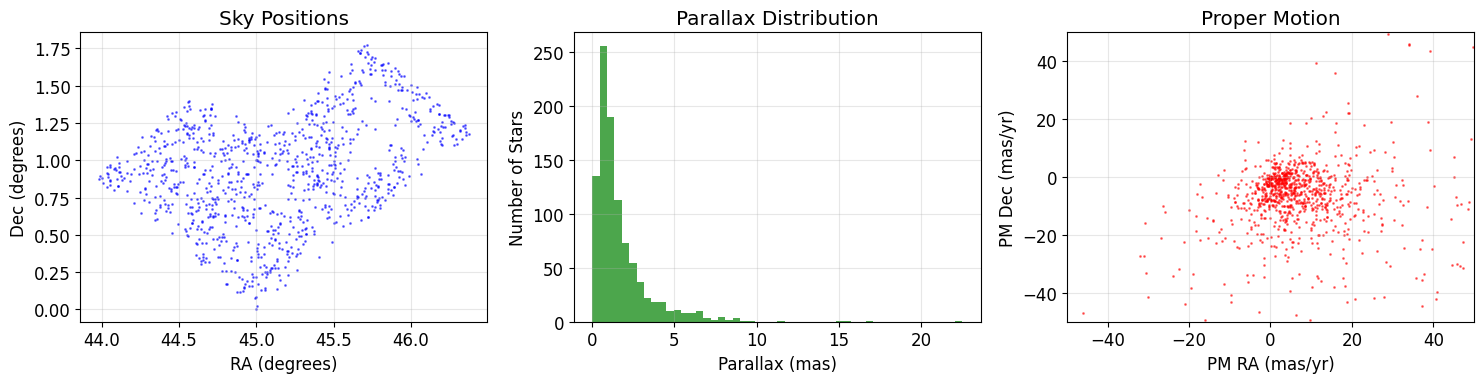

In [10]:
# Visualize Gaia data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Sky positions
axes[0].scatter(gaia_df['ra'], gaia_df['dec'], 
               s=1, alpha=0.5, c='blue')
axes[0].set_xlabel('RA (degrees)')
axes[0].set_ylabel('Dec (degrees)')
axes[0].set_title('Sky Positions')
axes[0].grid(True, alpha=0.3)

# Parallax distribution
parallax_clean = gaia_df['parallax'].dropna()
parallax_positive = parallax_clean[parallax_clean > 0]
if len(parallax_positive) > 0:
    axes[1].hist(parallax_positive, bins=50, alpha=0.7, color='green')
    axes[1].set_xlabel('Parallax (mas)')
    axes[1].set_ylabel('Number of Stars')
    axes[1].set_title('Parallax Distribution')
    axes[1].grid(True, alpha=0.3)

# Proper motion
pmra_clean = gaia_df['pmra'].dropna()
pmdec_clean = gaia_df['pmdec'].dropna()
if len(pmra_clean) > 0 and len(pmdec_clean) > 0:
    # Take same number of points
    n_points = min(len(pmra_clean), len(pmdec_clean))
    axes[2].scatter(pmra_clean[:n_points], pmdec_clean[:n_points], 
                   s=1, alpha=0.5, c='red')
    axes[2].set_xlabel('PM RA (mas/yr)')
    axes[2].set_ylabel('PM Dec (mas/yr)')
    axes[2].set_title('Proper Motion')
    axes[2].set_xlim(-50, 50)
    axes[2].set_ylim(-50, 50)
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Save Gaia sample for later use
gaia_df.to_csv('gaia_sample.csv', index=False)
print('✅ Saved Gaia sample to gaia_sample.csv')

✅ Saved Gaia sample to gaia_sample.csv


## Summary: Data Access Patterns

Here's a quick reference for loading different data types:

### Images (gz10)
```python
data = load_dataset('MultimodalUniverse/gz10', streaming=True)
image = data[0]['rgb_image']  # PIL Image
label = data[0]['gz10_label']  # Galaxy type
```

### Spectra (SDSS)
```python
data = load_dataset('MultimodalUniverse/sdss', streaming=True)
spectrum_dict = data[0]['spectrum']  # Dictionary
wavelength = spectrum_dict['lambda']  # Note: uses 'lambda' not 'wavelength'
flux = spectrum_dict['flux']
```

### Time Series (TESS/PLAsTiCC)
```python
# TESS (uppercase RA/DEC)
data = load_dataset('MultimodalUniverse/tess', streaming=True)
lightcurve = data[0]['lightcurve']  # Dictionary
ra, dec = data[0]['RA'], data[0]['DEC']

# PLAsTiCC
data = load_dataset('MultimodalUniverse/plasticc', streaming=True)
lightcurve = data[0]['lightcurve']  # Dictionary with time, band, flux
```

### Catalogs (Gaia)
```python
data = load_dataset('MultimodalUniverse/gaia', split='train[:1000]')
ra, dec = data[0]['ra'], data[0]['dec']  # lowercase!
astrometry = data[0]['astrometry']  # Dictionary with parallax, pm, etc.
```

## Key Tips

1. **Field Names Vary**: Check exact field names for each dataset
2. **Coordinate Conventions**: Gaia uses lowercase 'ra'/'dec', TESS uses uppercase 'RA'/'DEC'
3. **Data Structures**: Many fields are dictionaries (lightcurve, spectrum, astrometry)
4. **Memory Management**: Use `streaming=True` for large datasets
5. **Data Quality**: Always check for NaN/invalid values

## Next Steps

Continue to `03_cross_matching.ipynb` to learn how to combine data from multiple surveys!